In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

## Data Import

In [4]:
df1=pd.read_csv('shipping_tag1.csv')
df2=pd.read_csv('shipping_tag2.csv')

In [5]:
df1.sample(10)


,tag,message
177841,InTransit,Package processed
763177,OutForDelivery,Out for Delivery
595029,InTransit,Incoming data delivery by the sender
429463,InTransit,La verifica per lo svincolo della spedizione è...
665290,InfoReceived,Order information received
97891,InTransit,Shipment tendered to UPS Mail Innovations
387220,InTransit,Accepted at USPS Destination Sort Facility
753433,OutForDelivery,Out for Delivery
191695,InTransit,Arrived at UPS Facility
160923,InfoReceived,"Parcel Data Received, Shipment In Route To US ..."


In [6]:
df2.head()

,tag,message,original_message
0,AttemptFail,"Vi har været forbi med din forsendelse, men vi...",NaN
1,AttemptFail,ATTEMPTED DELIVERY,NaN
2,AttemptFail,Delivery attempt,NaN
3,AttemptFail,Delivery was not possible. The recipient will ...,NaN
4,AttemptFail,"Vi har været forbi med din forsendelse, men vi...",NaN


In [7]:
del df2['original_message']

In [8]:
df=pd.concat([df1,df2])

In [9]:
df.head()

,tag,message
0,AttemptFail,Próba doręczenia
1,AttemptFail,Delivery attempt
2,AttemptFail,"Vi har været forbi med din forsendelse, men vi..."
3,AttemptFail,Delivery attempt
4,AttemptFail,Delivery attempted; recipient not home


## Data Cleaning

In [10]:
#check duplicates
sum(df.duplicated())

953786

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
#check messages with multiple tags
message_count=df['message'].value_counts()
dup_message=message_count[message_count>1].index
len(dup_message)

137

In [13]:
#drop those with multiple tags
df=df[~df['message'].isin(dup_message)]

In [14]:
## imbalance class
df.tag.value_counts()

InTransit             4661
Delivered             1862
AvailableForPickup     459
Exception              273
AttemptFail            216
InfoReceived           191
OutForDelivery         174
Name: tag, dtype: int64

In [15]:
## Bootstraping other classes except for InTransit
df_delivered=df[df['tag']=='Delivered'].sample(n=len(df[df['tag']=='InTransit']),replace=True)
df_intransit=df[df['tag']=='InTransit']
df_availableforpickup=df[df['tag']=='AvailableForPickup'].sample(n=len(df[df['tag']=='InTransit']),replace=True)
df_exception=df[df['tag']=='Exception'].sample(n=len(df[df['tag']=='InTransit']),replace=True)
df_attemptfail=df[df['tag']=='AttemptFail'].sample(n=len(df[df['tag']=='InTransit']),replace=True)
df_inforeceived=df[df['tag']=='InfoReceived'].sample(n=len(df[df['tag']=='InTransit']),replace=True)
df_outfordelivery=df[df['tag']=='OutForDelivery'].sample(n=len(df[df['tag']=='InTransit']),replace=True)

In [16]:
df=pd.concat([df_delivered,df_intransit,df_availableforpickup,df_exception,df_attemptfail,df_inforeceived,df_outfordelivery])

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Delivered'),
  Text(1, 0, 'InTransit'),
  Text(2, 0, 'AvailableForPickup'),
  Text(3, 0, 'Exception'),
  Text(4, 0, 'AttemptFail'),
  Text(5, 0, 'InfoReceived'),
  Text(6, 0, 'OutForDelivery')])

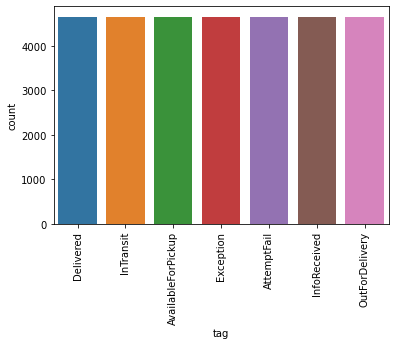

In [17]:
sns.countplot(data=df,x='tag')
plt.xticks(rotation=90)

In [18]:
df['tag']=df['tag'].astype('category')
df['tag_code']=df['tag'].cat.codes
code_map=dict(zip(df['tag'].cat.codes,df['tag']))

In [19]:
df.sample(100)

,tag,message,tag_code
730177,OutForDelivery,The partner Joel Alarcon Blonde arrives at des...,6
150,AttemptFail,"Delivery attempt, recipient is unknown",0
4549,AvailableForPickup,Awaiting collection at PERTH BUSINESS CENTRE,1
618817,InfoReceived,Shipment created and label generated APC LAX,5
708421,OutForDelivery,"Your post is out for delivery GREYSTONES, CO W...",6
...,...,...,...
767486,Exception,We're not able to deliver your parcel. Please ...,3
74381,Exception,The street number is incorrect. This may delay...,3
73315,Exception,EXCEPTION - The parcel has been rescheduled fo...,3
0,AttemptFail,Próba doręczenia,0


## NLP

In [109]:
import spacy
import spacy_fastlang
##from googletrans import Translator  ## online translator accessing google's api
import argostranslate.package       ## offline translator
import argostranslate.translate

In [45]:
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("language_detector")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [46]:
## build custom stopword list
real_stopwords=stopwords-{"not","n't","out",'re'}

In [47]:
## use ner tag to replace location, name
def ner_replacement(article):
    doc=nlp(article)
    ner=[(token.text,token.label_) for token in doc.ents]
    for text, entity in ner:
        article=article.replace(text,entity)
    return article


In [48]:
## eg
ner_replacement('The parcel has been delivered in los angeles')


'The parcel has been delivered in GPE'

In [39]:
arg_support_lang=\
['ar',
 'az',
 'ca',
 'zh',
 'cs',
 'da',
 'nl',
 'eo',
 'fi',
 'fr',
 'de',
 'el',
 'he',
 'hi',
 'hu',
 'id',
 'ga',
 'it',
 'ja',
 'ko',
 'fa',
 'pl',
 'pt',
 'ru',
 'sk',
 'es',
 'sv',
 'th',
 'tr',
 'uk']

In [41]:

#Download and install Argos Translate package, run this cell first time running the code.
# from_code =arg_support_lang
# argostranslate.package.update_package_index()
# available_packages = argostranslate.package.get_available_packages()
# for code in from_code:
#     package_to_install = next(
#         filter(
#             lambda x: x.from_code == code, available_packages
#         )
#     )
#     argostranslate.package.install_from_path(package_to_install.download())
# package_to_install = next(
#         filter(
#             lambda x: x.to_code == 'en', available_packages
#         )
#     )
# argostranslate.package.install_from_path(package_to_install.download())

(IncompleteRead(44003328 bytes read, 69144934 more expected),)
(IncompleteRead(80195584 bytes read, 40365639 more expected),)


In [60]:
## Construct the tokenizer
def cust_lemmatizer(article):
    doc=nlp(article)
    # if doc._.language=='en':
    #     en_article=article
    if doc._.language in arg_support_lang:
        en_article = argostranslate.translate.translate(article, doc._.language, 'en')
    else:
        en_article=article
        # time.sleep(2)
        # en_article=Translator().translate(article, dest='en').text
    simplified_en_article=ner_replacement(en_article)
    clean_en_article=' '.join(re.findall("[\w _\-']+",simplified_en_article))
    doc1=nlp(clean_en_article)
    lemmas=[token.lemma_ for token in doc1 if not token.is_space]
    return [lemma for lemma in lemmas if lemma not in real_stopwords]
    
    

In [126]:
## e.g.
cust_lemmatizer("The parcel has been delivered in los angeles")


['parcel', 'deliver', 'GPE']

In [65]:
X=df.message.values
y=df.tag_code.values

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=3)

In [67]:
## vectorize messages
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=cust_lemmatizer,ngram_range=(1,2),min_df=3)

In [68]:
X_train_vector=vectorizer.fit_transform(X_train)

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
X_test_vector=vectorizer.transform(X_test)

In [70]:
print(X_train_vector.toarray().shape)
print(X_test_vector.toarray().shape)

(26101, 4515)
(6526, 4515)


## Modeling

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [72]:
## Algorithm, hyperparamter gridsearch
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {
            'C': [1, 5,10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale','auto']
        }  
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params' : {
                'max_depth': [4, 6, 8],
                'n_estimators': [ 100, 250,500,750],
                "learning_rate": [0.01,0.1,0.3],
                'colsample_bytree': np.arange(0.5, 1.0, 0.1),
                'colsample_bylevel': np.arange(0.5, 1.0, 0.1)
        }
    },
     'nb' : {
        'model': MultinomialNB(),
        'params': {
            'alpha': np.arange(1,10,1)
        }
     },
    'logistics regression' : {
    'model': LogisticRegression(),
    'params': {
        'penalty': ['l2',None],
        'solver': ['lbfgs','newton-cg','sag','saga']
        }
    }
}

In [73]:
scores = []

for model_name, mp in model_params.items():
    model =  RandomizedSearchCV(mp['model'], mp['params'], cv=3, n_iter=20)
    model.fit(X_train_vector, y_train)
    scores.append({
        'model': model_name,
        'best_score': round(model.best_score_,2),
        'best_params': model.best_params_
    })
    
pd.DataFrame(scores,columns=['model','best_score','best_params'])

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter

,model,best_score,best_params
0,svm,0.99,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 5}"
1,xgboost,0.99,"{'n_estimators': 750, 'max_depth': 6, 'learnin..."
2,nb,0.96,{'alpha': 1}
3,logistics regression,0.99,"{'solver': 'sag', 'penalty': None}"


In [106]:
xgb=XGBClassifier(n_estimators=750, max_depth=6, learning_rate=0.1,colsample_bylevel=0.6,colsample_bytree= 0.8)
xgb.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=750, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [75]:
svm=SVC(kernel='rbf',gamma='scale',C=5,probability=True)
svm.fit(X_train_vector, y_train)

SVC(C=5, probability=True)

In [102]:
lr=LogisticRegression(solver='sag',penalty=None)
lr.fit(X_train_vector, y_train)

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty=None, solver='sag')

In [107]:
## SVM and XGboost similar performance, compare on test set
print('SVM:',svm.score(X_test_vector,y_test))
print('XGBoost:',xgb.score(X_test_vector,y_test))
print('Logistics Regression:',lr.score(X_test_vector,y_test))

SVM: 0.990959239963224
XGBoost: 0.9904995403003372
Logistics Regression: 0.9918786392889979


In [78]:
## further comparison
from sklearn.metrics import classification_report

print('SVM: \n', classification_report(y_test,svm.predict(X_test_vector),target_names=code_map.values()))

SVM: 
                     precision    recall  f1-score   support

         Delivered       0.99      1.00      1.00       933
         InTransit       0.99      1.00      1.00       932
AvailableForPickup       0.99      0.98      0.99       933
         Exception       0.99      0.99      0.99       932
       AttemptFail       0.98      0.97      0.98       932
      InfoReceived       0.99      0.99      0.99       932
    OutForDelivery       0.99      1.00      1.00       932

          accuracy                           0.99      6526
         macro avg       0.99      0.99      0.99      6526
      weighted avg       0.99      0.99      0.99      6526



In [108]:
print('XGBoost: \n', classification_report(y_test,xgb.predict(X_test_vector),target_names=code_map.values()))

XGBoost: 
                     precision    recall  f1-score   support

         Delivered       0.99      0.99      0.99       933
         InTransit       0.99      1.00      1.00       932
AvailableForPickup       0.99      0.99      0.99       933
         Exception       0.98      0.99      0.99       932
       AttemptFail       0.98      0.97      0.97       932
      InfoReceived       0.99      0.99      0.99       932
    OutForDelivery       0.99      1.00      1.00       932

          accuracy                           0.99      6526
         macro avg       0.99      0.99      0.99      6526
      weighted avg       0.99      0.99      0.99      6526



In [104]:
print('Logistics Regression: \n', classification_report(y_test,lr.predict(X_test_vector),target_names=code_map.values()))

Logistics Regression: 
                     precision    recall  f1-score   support

         Delivered       0.99      1.00      1.00       933
         InTransit       0.99      1.00      1.00       932
AvailableForPickup       0.99      0.99      0.99       933
         Exception       1.00      0.99      0.99       932
       AttemptFail       0.98      0.97      0.98       932
      InfoReceived       0.99      0.99      0.99       932
    OutForDelivery       0.99      1.00      1.00       932

          accuracy                           0.99      6526
         macro avg       0.99      0.99      0.99      6526
      weighted avg       0.99      0.99      0.99      6526



In [81]:
# ## Three algorithm all work well, let's ensemble them
# from sklearn.ensemble import VotingClassifier
# classifiers=[('SVM',svm),
#              ('XGBoost',xgb),
#             ('Logistics Regression',lr)]
# clf=VotingClassifier(estimators=classifiers,voting='soft')
# clf.fit(X_train_vector,y_train)
# clf.score(X_test_vector,y_test)

In [82]:
# print(classification_report(y_test,clf.predict(X_test_vector),target_names=code_map.values()))

## Model Evaluation

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

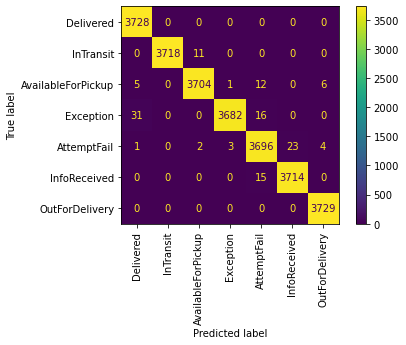

In [122]:
cm2=confusion_matrix(y_train,svm.predict(X_train_vector),labels=np.arange(0,7))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=code_map.values())
disp_train.plot()
plt.xticks(rotation=90)
plt.show()

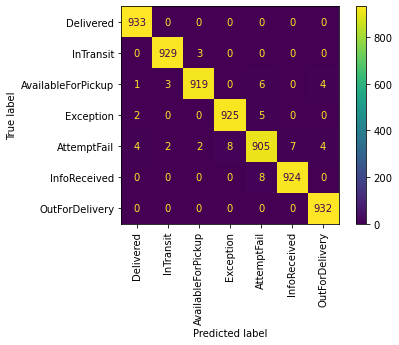

In [123]:
cm1=confusion_matrix(y_test,svm.predict(X_test_vector),labels=np.arange(0,7))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=code_map.values())
disp_test.plot()
plt.xticks(rotation=90)
plt.show()

In [124]:
## Print out wrongly classified messages
dfx=pd.DataFrame(X_test)
dfy=pd.DataFrame(y_test)
dfy_=pd.DataFrame(svm.predict(X_test_vector))
df_check=pd.concat([dfx,dfy,dfy_],axis=1)
df_check['true label']=df_check.iloc[:,1].map(code_map)
df_check['predict label']=df_check.iloc[:,2].map(code_map)
print(len(df_check[df_check['true label']!=df_check['predict label']]))
df_check[df_check['true label']!=df_check['predict label']]

59


,0,0,0,true label,predict label
127,Doręczono,2,4,Delivered,InTransit
145,On delivery,4,6,InTransit,OutForDelivery
191,Sendingen er utlevert.,2,4,Delivered,InTransit
245,We couldn't deliver your item as there was a p...,4,3,InTransit,Exception
320,Clearance processing complete at ONTARIO SERV...,4,5,InTransit,InfoReceived
375,Acceptance by the Post Services,4,5,InTransit,InfoReceived
444,Proof of Delivery,2,6,Delivered,OutForDelivery
497,MOVED,3,4,Exception,InTransit
570,Item delivered to the Addressee at the post of...,2,1,Delivered,AvailableForPickup
636,Item Despatched to Berwick Upon Tweed DO,4,5,InTransit,InfoReceived


In [87]:
## construct pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('vectorizer', vectorizer), ('svm', svm)])

In [88]:
def status_classify(status):
    if type(status)==str:
        status=[status]
    CLASS=pipe.predict(status)
    LABEL=[code_map[target] for target in CLASS]
    PROB=pipe.predict_proba(status)
    PROB.sort(axis=1)
    return list(zip(LABEL,PROB[:,-1]))

In [125]:
status_classify(["Votre envoi est disponible en point de retrait."])

[('AvailableForPickup', 0.9965748238599403)]